<a href="https://colab.research.google.com/github/rintrgthb/Joy-bioinformatics-division/blob/main/HW_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Для работы я выбрала "Mental Health & Social Media Balance Dataset" из Kaggle.

Бизнес-задача: Спрогнозировать, как количество времени, проведенное в социальных сетях и качество сна сказывается на уровне стресса человека.

ML-задача: задача регрессии - прогнозирование непрерывного числового значения на основе набора входных данных.


In [5]:
#подгружаю минимальные библиотеки и сам датасет
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('/Mental_Health_and_Social_Media_Balance_Dataset.csv')
df.head()

,User_ID,Age,Gender,Daily_Screen_Time(hrs),Sleep_Quality(1-10),Stress_Level(1-10),Days_Without_Social_Media,Exercise_Frequency(week),Social_Media_Platform,Happiness_Index(1-10)
0,U001,44,Male,3.1,7.0,6.0,2.0,5.0,Facebook,10.0
1,U002,30,Other,5.1,7.0,8.0,5.0,3.0,LinkedIn,10.0
2,U003,23,Other,7.4,6.0,7.0,1.0,3.0,YouTube,6.0
3,U004,36,Female,5.7,7.0,8.0,1.0,1.0,TikTok,8.0
4,U005,34,Female,7.0,4.0,7.0,5.0,1.0,X (Twitter),8.0


При выборе метрики я руководствовалась мнением о том, что в данном случае модель не несет за собой какой-то финансовой подложки - неправильное прогнозирование уровня стресса не приведет к экономическим проблемам, а также, скорее всего, не нанесет вреда пациентам, если исследование будет проводиться психологами или психотерапевтами. Поэтому строгое использованием метрик, в которых положительные и отрицательные отклонения от истинного значения учитываются с разными весами, не требуется. Тем не менее, оно может помочь при ранней диагностике интернет-зависимостей, поэтому высокая точность всё же необходима.
Среднеквадратичная ошибка сильно штрафует, что дает необъективную оценку при наличии выбросов - логичность использования даннлой метрики можно понять после EDA.
Для начала предлагаю использование базовой метрики - коэффициента детерминации (R2), а также среднюю абсолютную ошибку (MAE), что менее чувствительна к выбросам, чем MSE.

In [9]:
#EDA
df.columns

Index(['User_ID', 'Age', 'Gender', 'Daily_Screen_Time(hrs)',
       'Sleep_Quality(1-10)', 'Stress_Level(1-10)',
       'Days_Without_Social_Media', 'Exercise_Frequency(week)',
       'Social_Media_Platform', 'Happiness_Index(1-10)'],
      dtype='object')

In [10]:
df.shape
#датасет из 10 колоной и 500 строк

(500, 10)

In [12]:
df.dtypes
#часть колонок представлена дробными числами, возраст - целыми числами, а
#идентификатор пользователя - строчными данными

,0
User_ID,object
Age,int64
Gender,object
Daily_Screen_Time(hrs),float64
Sleep_Quality(1-10),float64
Stress_Level(1-10),float64
Days_Without_Social_Media,float64
Exercise_Frequency(week),float64
Social_Media_Platform,object
Happiness_Index(1-10),float64


In [17]:
#посмотрим пропущенные значения
df.isna().sum() #пропущенных значений нет - не нужна фильтрация или заполнение их средним значением

,0
User_ID,0
Age,0
Gender,0
Daily_Screen_Time(hrs),0
Sleep_Quality(1-10),0
Stress_Level(1-10),0
Days_Without_Social_Media,0
Exercise_Frequency(week),0
Social_Media_Platform,0
Happiness_Index(1-10),0


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   User_ID                    500 non-null    object 
 1   Age                        500 non-null    int64  
 2   Gender                     500 non-null    object 
 3   Daily_Screen_Time(hrs)     500 non-null    float64
 4   Sleep_Quality(1-10)        500 non-null    float64
 5   Stress_Level(1-10)         500 non-null    float64
 6   Days_Without_Social_Media  500 non-null    float64
 7   Exercise_Frequency(week)   500 non-null    float64
 8   Social_Media_Platform      500 non-null    object 
 9   Happiness_Index(1-10)      500 non-null    float64
dtypes: float64(6), int64(1), object(3)
memory usage: 39.2+ KB


In [24]:
cat_cols = df.select_dtypes(include='object')
cat_cols.head()


,User_ID,Gender,Social_Media_Platform
0,U001,Male,Facebook
1,U002,Other,LinkedIn
2,U003,Other,YouTube
3,U004,Female,TikTok
4,U005,Female,X (Twitter)


Мне показалось странным наличие значения 'others' в колонке пола, что некорректно для медицинских и психологических исследований, поэтому я решила отбросить любые разделения предсказаний для мужчин и женщин, а не уменьшать выборку.:

In [25]:
num_cols = df.select_dtypes(exclude='object')
num_cols.describe()

,Age,Daily_Screen_Time(hrs),Sleep_Quality(1-10),Stress_Level(1-10),Days_Without_Social_Media,Exercise_Frequency(week),Happiness_Index(1-10)
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,32.988000,5.530000,6.304000,6.618000,3.134000,2.448000,8.376000
std,9.960637,1.734877,1.529792,1.542996,1.858751,1.428067,1.524228
min,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,4.000000
25%,24.000000,4.300000,5.000000,6.000000,2.000000,1.000000,7.000000
50%,34.000000,5.600000,6.000000,7.000000,3.000000,2.000000,9.000000
75%,41.000000,6.700000,7.000000,8.000000,5.000000,3.000000,10.000000
max,49.000000,10.800000,10.000000,10.000000,9.000000,7.000000,10.000000


In [27]:
num_cols.shape

(500, 7)

По таблице информационной сводки для числовых колонок можно заметить, что странных значений нет (например, слишком малого возраста опрашиваемого или времени, проводимого в социальных сетях в сутки более 24 часов)
Я решила рассматривать зависимость времени и уровня стресса/качества сна, хотя есть ещё один признак, который можно было бы включить в исследование - уровень счастья. По моему мнению он не может быть доказательным, так как счастье - понятие субъективное, поэтому его прогноз отбросился.


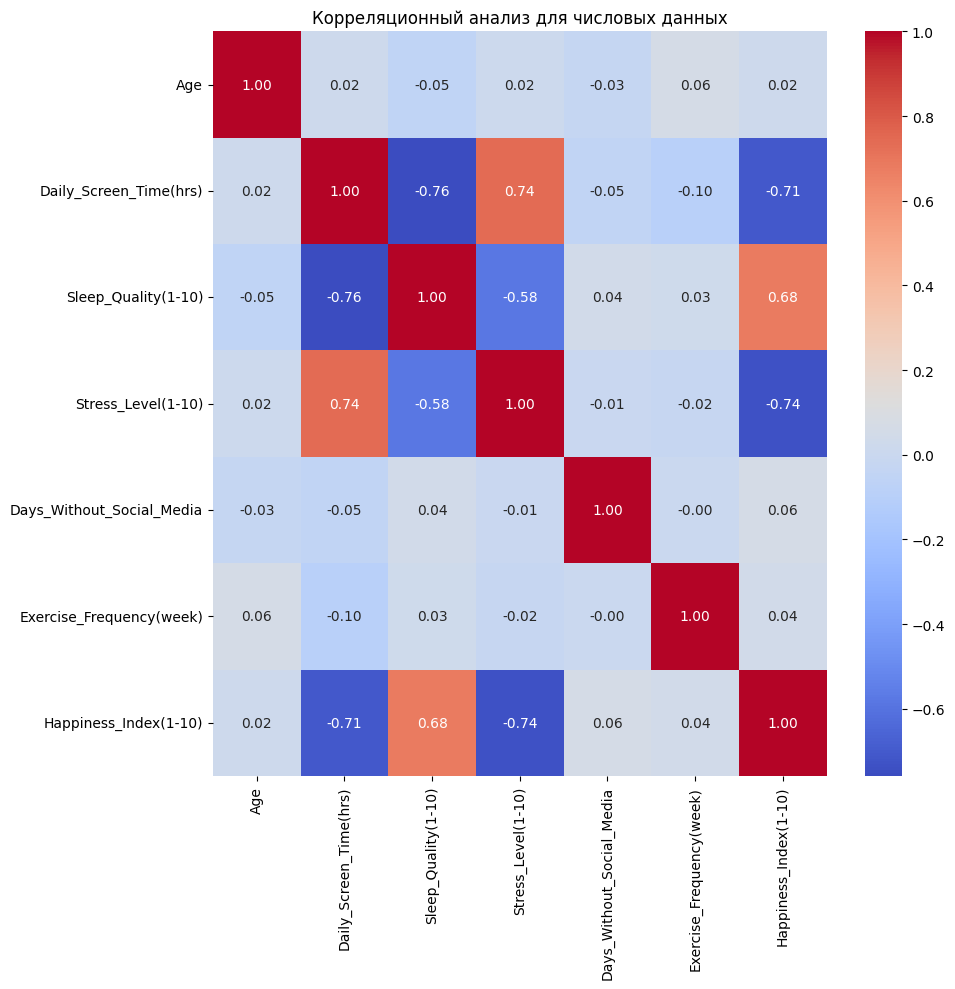

In [29]:
#визуализация
import matplotlib.pyplot as plt
import seaborn as sns

#сделаем корреляционный анализ для числовых данных
plt.figure(figsize=(10, 10))
correlation_matrix = num_cols.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляционный анализ для числовых данных')
plt.tight_layout()
plt.show()

Можем заметить, что имеется прямая зависимость уровня стресса от количества времени, проведенного в социальных сетях (0.74) и обратная зависимость уровня стресса от качества сна (-0.58).

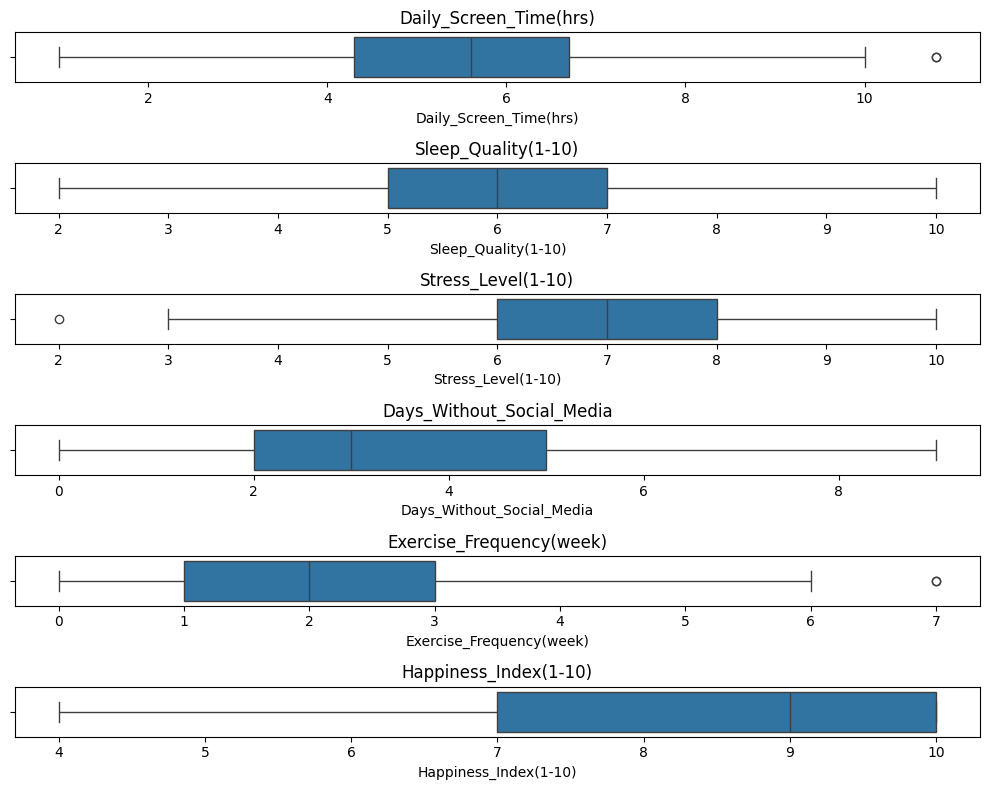

In [31]:
#посмотрим выбросы с помощью boxplot
cols = ['Daily_Screen_Time(hrs)', 'Sleep_Quality(1-10)', 'Stress_Level(1-10)',
       'Days_Without_Social_Media', 'Exercise_Frequency(week)', 'Happiness_Index(1-10)']

plt.figure(figsize=(10, 8))

for i, col in enumerate(cols):
    plt.subplot(len(cols), 1, i + 1)
    sns.boxplot(x=col, data=df)
    plt.title(col)
    plt.tight_layout()

plt.show()

Можем заметить сильные выбросы в некоторых значениях, поэтому точно не берем метрику MSE.

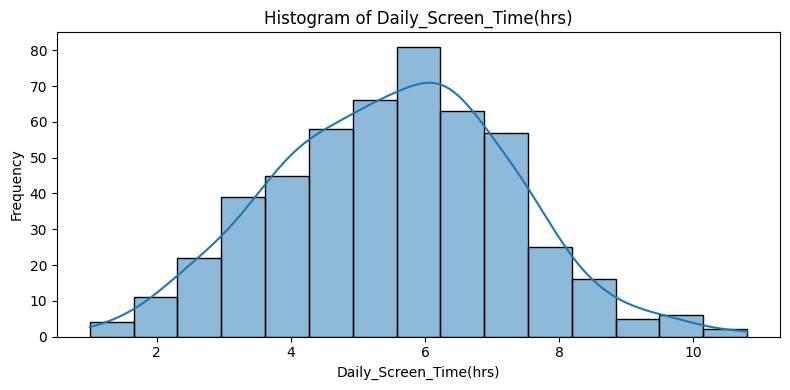

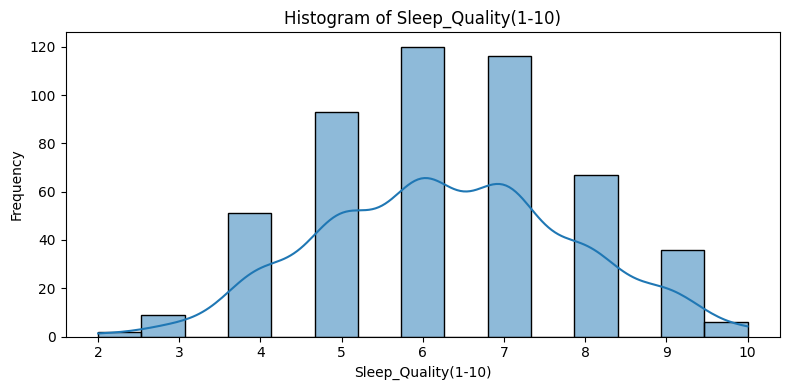

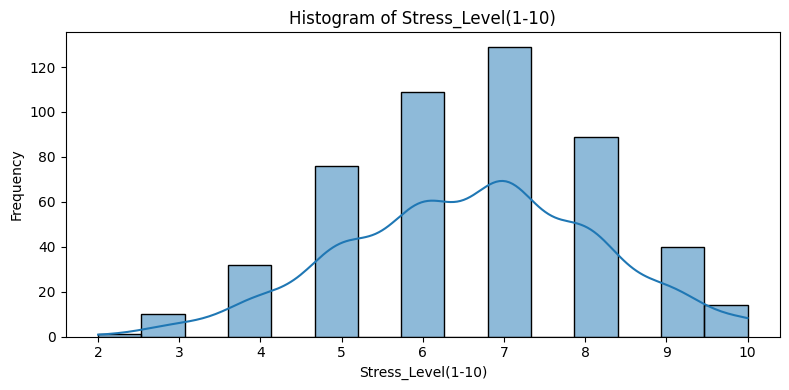

In [33]:
#посмотрим распределение признаков с помощью гистограммы
hist_plot = ['Daily_Screen_Time(hrs)', 'Sleep_Quality(1-10)', 'Stress_Level(1-10)']
for feature in hist_plot:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[feature], kde=True, bins=15)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

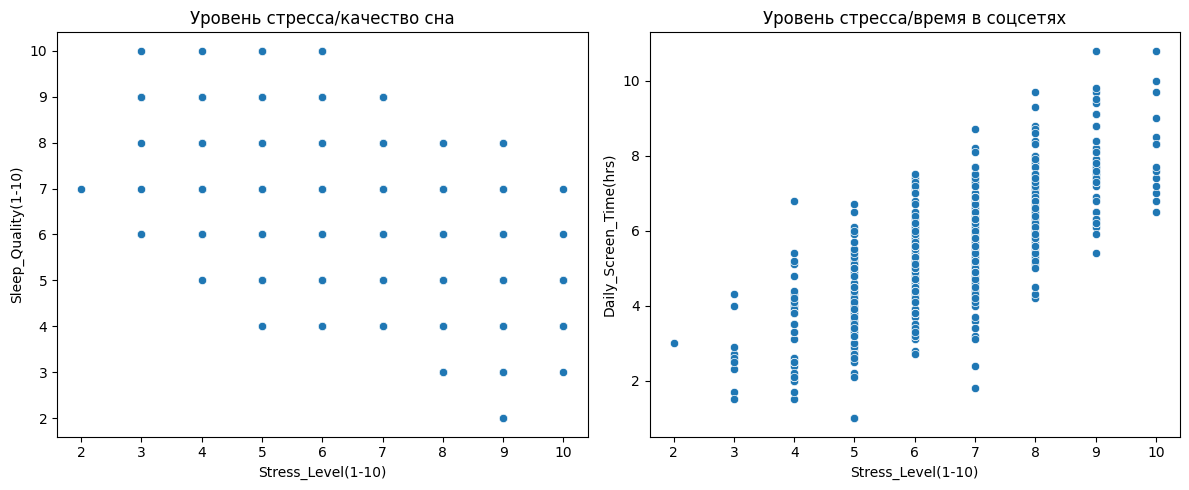

In [34]:
#посмотрим отношения между переменными уровень стресса/качество сна и уровень стресса/время в соц сетях
#с помощью scatter plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x='Stress_Level(1-10)', y='Sleep_Quality(1-10)', data=df)
plt.title('Уровень стресса/качество сна')

plt.subplot(1, 2, 2)
sns.scatterplot(x='Stress_Level(1-10)', y='Daily_Screen_Time(hrs)', data=df)
plt.title('Уровень стресса/время в соцсетях')

plt.tight_layout()
plt.show()

Можем заметить, что корреляция между уровнем стресса и качеством сна довольно слабая, можно срезать выбросы с обоих концов и уменьшить выборку, если после проверок модели это улучшит качество предстказаний, на данный момент оставим, как есть. В дальнейших исследованиях требуется бОльшая выборка.

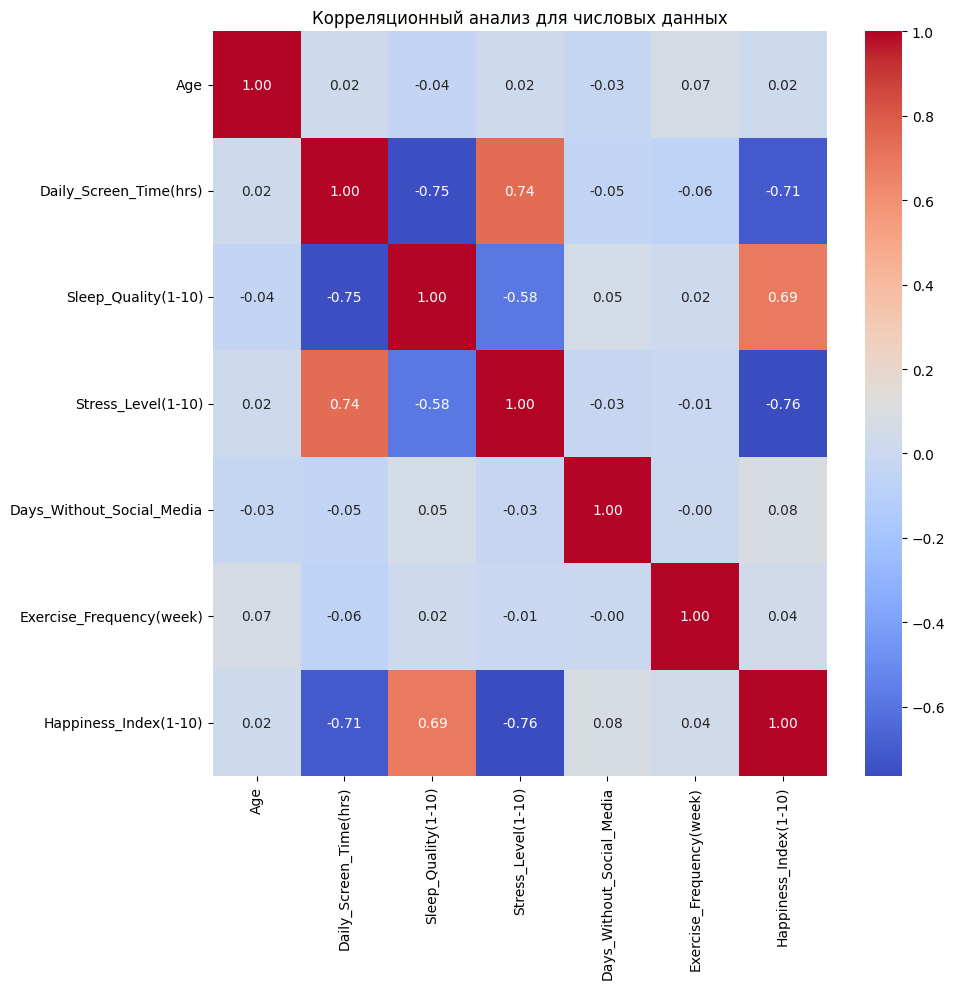

In [35]:
#попробуем ещё сделать корреляцию Спирмена для поиска нелинейных зависимостей

plt.figure(figsize=(10, 10))
correlation_matrix = num_cols.corr(method='spearman')
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляционный анализ для числовых данных')
plt.tight_layout()
plt.show()

#особой разницы нет